In [41]:
import importlib

import matplotlib.pyplot as plt
import numpy as np

# Import relevant python packages
from gpet import utils, edgetrace, dataset
%matplotlib inline

In [42]:
importlib.reload(gpet)
importlib.reload(utils)
importlib.reload(dataset)

<module 'gpet_oct.dataset' from '/Users/uzaykaradag/Documents/School/Dissertation/gpr-oct-segmentation/gpet_oct/dataset.py'>

### Loading and splitting the dataset
Here the dataset is loaded as scans and masks and split into an **80-20 train-test** split. This results in **4192 train** samples from and **1048 test** samples.

In [44]:
import os

scan_dir = '/Users/uzaykaradag/Documents/School/Dissertation/gpr-oct-segmentation/data/scans'
mask_dir = '/Users/uzaykaradag/Documents/School/Dissertation/gpr-oct-segmentation/data/pred'

# Get the list of scan and mask filenames
scan_files = set(os.listdir(scan_dir))
mask_files = set(os.listdir(mask_dir))

# Get only the matching scan files
matching_files = list(scan_files.intersection(mask_files))

# Ensure we have matching files
if not matching_files:
    raise ValueError("No matching files found between scans and masks!")

In [45]:
# Load the data
scans, elm_coords = dataset.load_dataset(matching_files, scan_dir, mask_dir)

In [46]:
# Test the function using a singular scan
test_idx = 0
test_scan = scans[test_idx]
test_elm = elm_coords[test_idx]

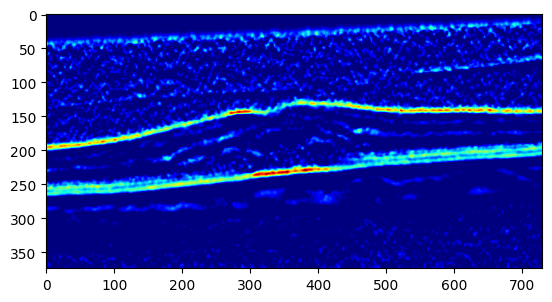

In [47]:
# Create a kernel for edge detection
kernel = utils.kernel_builder(size=(21, 5), unit=False, normalize=True)
# Compute the gradient image
test_edge_map = utils.comp_grad_img(test_scan, kernel)

plt.imshow(test_edge_map, cmap='jet')

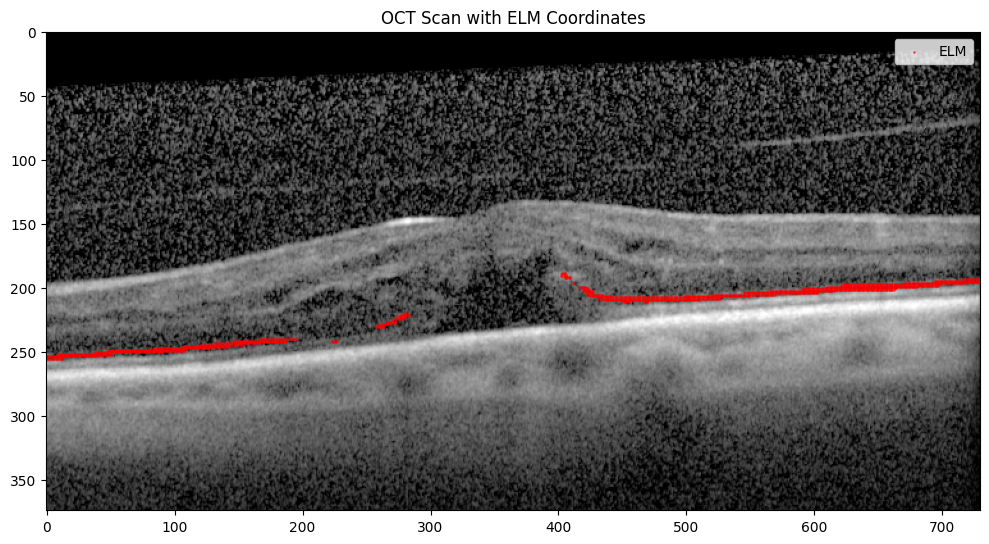

In [48]:
utils.plot_elm(test_scan, test_elm)

In [49]:
test_elm

array([[253,   0],
       [254,   0],
       [255,   0],
       ...,
       [194, 729],
       [195, 729],
       [193, 729]])

In [51]:
# Get initialization edges from the true_elm_coords aka mask
init = test_elm[[0, -1], :][:, [1, 0]]
init

array([[  0, 253],
       [729, 193]])

In [54]:
gp_kwargs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True
)

# Instantiate algorithm using parameters in __init__()
elm_tracer = gpet.GPEdgeTracer(init, test_edge_map, **gp_kwargs)

In [55]:
edge_pred, edge_credint = elm_tracer()

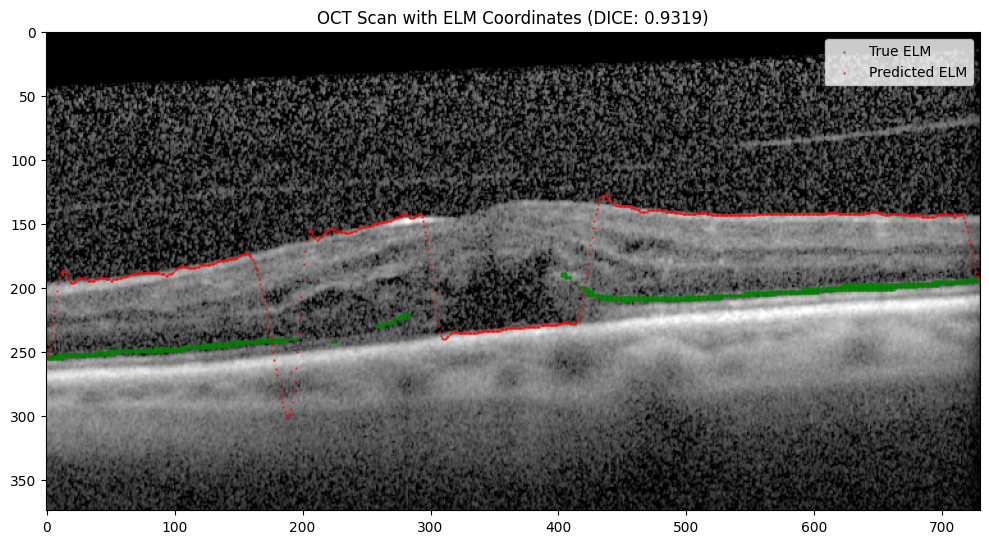

In [56]:
utils.plot_elm(test_scan, edge_pred, compare=True, true_elm_coords=test_elm)

**Experimenting with the use of the variable `obs`**

In [57]:
test_elm

array([[253,   0],
       [254,   0],
       [255,   0],
       ...,
       [194, 729],
       [195, 729],
       [193, 729]])

**Here I randomly select 100 xy-points as the `obs` variable.**

In [58]:
# Randomly select 100 rows
test_obs = test_elm[np.random.choice(test_elm.shape[0], size=100, replace=False), :]
test_obs = test_obs[test_obs[:, 0].argsort()]

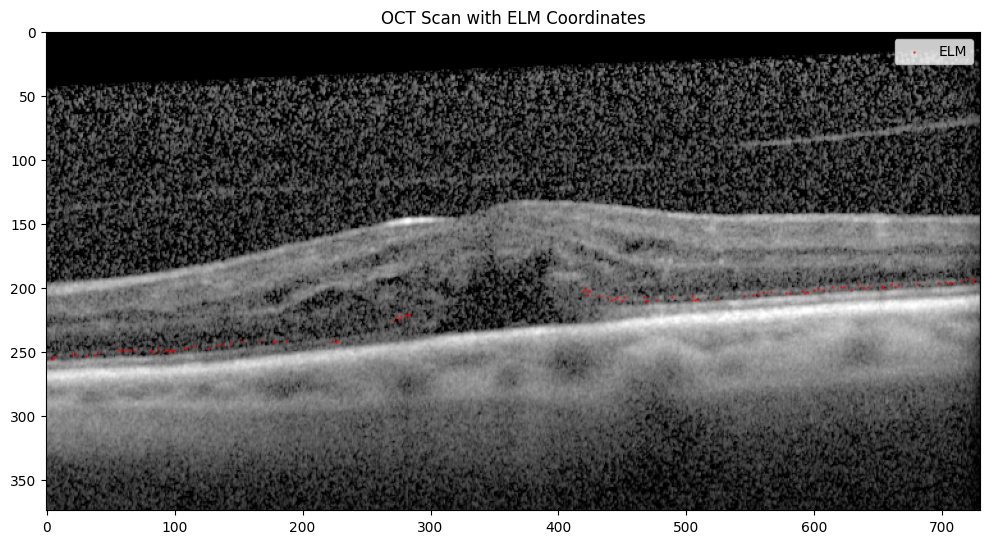

In [59]:
utils.plot_elm(test_scan, test_obs)

In [60]:
test_obs[:, [0, 1]] = test_obs[:, [1, 0]]  # yx-plane to xy-plane

In [62]:
gp_kwargs_obs = dict(
    kernel_options={'kernel': 'Matern', 'sigma_f': 60, 'length_scale': 20, 'nu': 2.5},
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True,
    obs=test_obs
)

# Instantiate algorithm using parameters in __init__()
elm_tracer_obs = gpet.GPEdgeTracer(init, test_edge_map, **gp_kwargs_obs)

In [63]:
# __call__() parameters and run algorithm on test image
edge_pred_obs, edge_credint_obs = elm_tracer_obs()

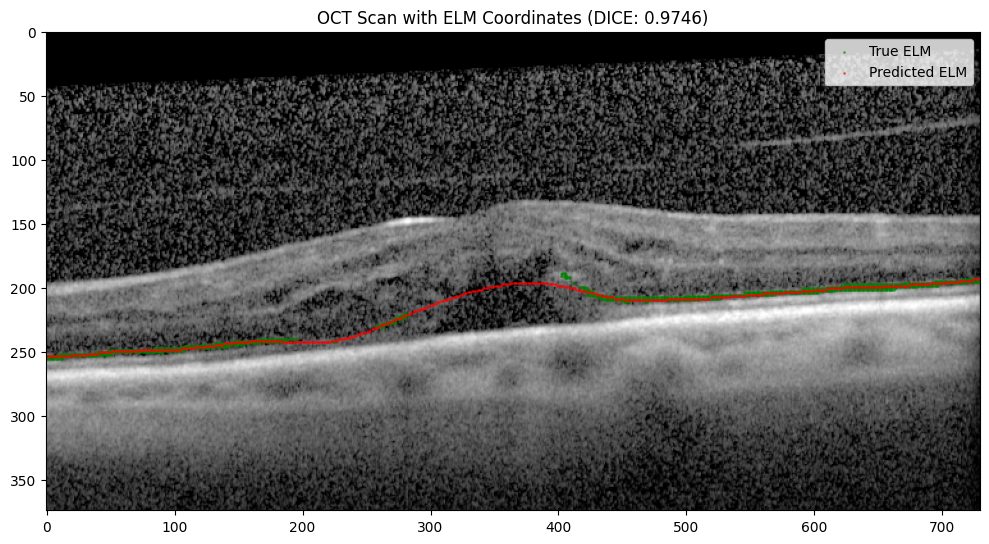

In [64]:
utils.plot_elm(test_scan, edge_pred_obs, compare=True, true_elm_coords=test_elm)

In [65]:
kernel_options = {
    'kernel': 'ExpSineSquared',
    'sigma_f': 1.0,
    'length_scale': 10.0,
    'period': 10.0
}

gp_kwargs_obs = dict(
    kernel_options=kernel_options,
    delta_x=8,
    score_thresh=0.5,
    N_samples=1000,
    seed=1,
    noise_y=0.5,
    keep_ratio=0.1,
    pixel_thresh=5,
    fix_endpoints=True,
    return_std=True,
    obs=test_obs
)

# Instantiate algorithm using parameters in __init__()
elm_tracer_obs = gpet.GPEdgeTracer(init, test_edge_map, **gp_kwargs_obs)

gp_tracer_exp = gpet.GPEdgeTracer(init, test_edge_map, kernel_options=kernel_options)
elm_pred_exp = gp_tracer_exp()

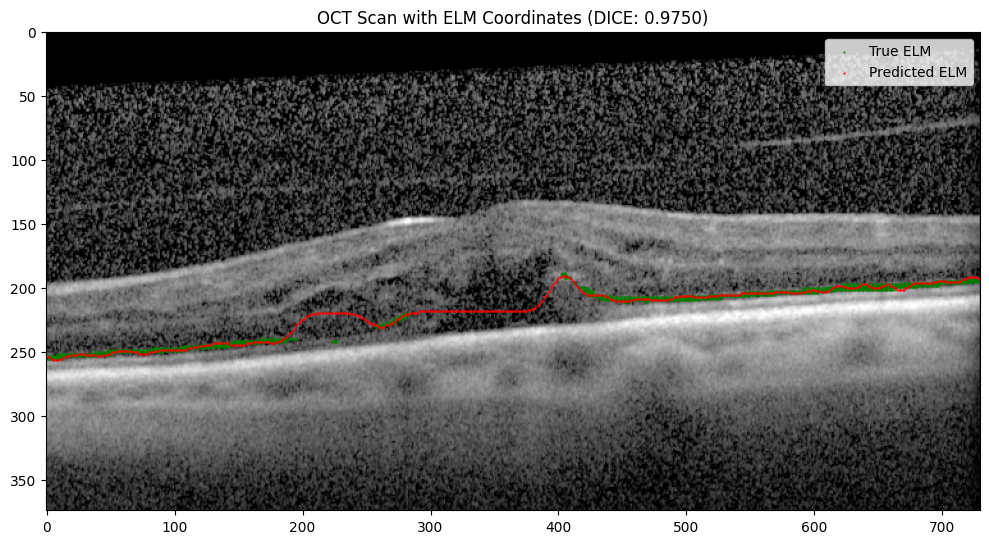

In [67]:
utils.plot_elm(test_scan, elm_pred_exp, compare=True, true_elm_coords=test_elm)

## IDEA: DETECT JUMPS IN THE OBSERVATIONS (PREDICTIONS FROM SEGNET) AND PERFORM TWO STEP GPR EDGE TRACING W/ A JUMP THRESHOLD VARIABLE